# BUILD DATA

In [3]:
import linearmodels
import os 
import shutil
import numpy as np
import pandas as pd
from pathlib import Path
home = str(Path.home())

#os.chdir('C:/Users/eurhope/Desktop/DFG/geowatchlab/3_prix_alim/batch9_geowatchlabs-3-markets/src')


In [ ]:
#
# MAKE DATA FROM RAW FILES
#

from import_functions.import_and_aggregate import *

data = import_dataset()
output_file = 'aggregated_match_for_FSMS_files_with_yields_with_price.csv'
shutil.copy(output_file, home + '/' + output_file)


In [4]:

from preprocessing.preprocessing import *

df_raw = preprocess_FSMS_files_with_yields_and_prices()

#
# IMPORT DATA
#

from import_functions.get_agricultural_geo import *
from import_functions.clean_wilaya_moughataa import *
from import_functions.fill_geo_data_dec12 import *

file_agg = './aggregated_match_for_FSMS_files_with_yields.csv'
file_agg = './standardized_aggregated_dataset.csv'
file_agg = './aggregated_match_for_FSMS_files_with_yields_with_price.csv'

#df_raw = pd.read_csv(file_agg)

#
# CLEAN FROM MONTH
#

df = df_raw.dropna(subset={'month'})
df = df[df['month'].isin(['Decembre', 'Juin'])]

#
# remove price columns
#
df = df.drop(columns={'price', 'category', 'cmid', 'ptid', 'umid',
                      'catid', 'sn', 'currency', 'unit', 'cmname',
                      'mktname', 'mktid'})
df = df.drop_duplicates()

# 
# FILL LATITUDE, LONGITUDE AND MOUGHATAA FOR DEC 2012
# 

df = fill_geo_data_dec12(df)

#
# CLEAN WILAYA AND MOUGHATAA NAMES
#

list_moughataa = df.moughataa.unique()
list_wilaya = df.wilaya.unique()

df2 = clean_moughataa_col(df)
df2 = clean_wilaya_col(df2)

list_moughataa2 = df2.moughataa.unique()
list_wilaya2 = df2.wilaya.unique()

df2_dec12 = df2[(df2.year == 2012) & (df2.month == 'Decembre')]


# CREATE HOUSEHOLD GROUPS FROM MOUGHATAA AND INCOME QUARTILE

In [6]:

#
# MAKE HOUSEHOLD GROUPS
#

cols = df2.columns
revenu_col = list(cols[cols.str.contains('revenu|rev')])
col_interest = ['ident', 'year', 'month',
                'wilaya', 'moughataa', 'commune', 'milieu', 'latitude', 'longitude',
                'LHZ', 'fcs', 'csi', 
                'Nb_hom', 'Nb_fem','TxDep', 'Equiv_ad'] + revenu_col
                
col_crop = []

dftest= df2[df2['year'] == 2012][['year', 'month', 'rev_percap', 'revenu_mens', 'revenu1']] 

df2a = df2[col_interest]
df2a = df2a.dropna(subset={'rev_percap'})

#df2a = df2a[df2a['month'].isin(['Juin'])]

col = 'rev_percap'

list_year = [2012, 2013, 2014, 2015]
list_month = ['Decembre', 'Juin']
list_data_year = []

for y in list_year:
    for m in list_month:
    
        df3 = df2a[(df2a['year'] == y) & (df2a['month'] == m)]    
    
        rev = pd.DataFrame(
                    {
                        "Mean": [np.mean(df3[col])],
                        "Min": [np.min(df3[col])],
                        "Max": [np.max(df3[col])],
                        "Q1": [np.quantile(df3[col], 0.25, axis=0)],
                        "Q2": [np.quantile(df3[col], 0.5, axis=0)],               
                        "Q3": [np.quantile(df3[col], 0.75, axis=0)],               
                    })        
            
        df3['rev_catg'] = np.select([(df3.rev_percap < rev.loc[0,'Q1']),
                                    (df3.rev_percap >=  rev.loc[0,'Q1']) & (df3.rev_percap <  rev.loc[0,'Q2']),
                                     (df3.rev_percap >= rev.loc[0,'Q2']) & (df3.rev_percap <  rev.loc[0,'Q3']),
                                    (df3.rev_percap >=  rev.loc[0,'Q3'])],
                                    ["1", "2", "3", "4"])
        
        list_data_year.append(df3)

df3 = pd.concat(list_data_year)
df3['house_catg'] = df3['moughataa'] + df3['rev_catg']

data = df3.groupby(['house_catg', 'year', 'month', 'moughataa', 'rev_catg'])['fcs', 'rev_percap'].mean().reset_index(drop=False)
  
datac = df3.value_counts(['house_catg', 'year', 'month']).reset_index(drop=False)
datac.columns = ['house_catg', 'year', 'month', 'n']

data = data.merge(datac, on = ['house_catg', 'year', 'month'], how = 'left')

#
# CREATE TIME COLUMN
# 

time_df = data[['year', 'month']].drop_duplicates()
time_df = time_df.sort_values('month', ascending=False).sort_values('year')
time_df = time_df.reset_index(drop=True).reset_index(drop=False)
time_df.columns = ['time', 'year', 'month']

data = data.merge(time_df, on = ['year', 'month'], how = 'left')
data = data.sort_values('time').reset_index(drop=True)

data = data.set_index(['house_catg', 'time'])

data['month_Decembre'] = pd.get_dummies(data)['month_Decembre']

data['rev_percap'] = data['rev_percap']/1000

C:\Users\eurhope\Anaconda3\envs\py.3.6\lib\site-packages\ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\eurhope\Anaconda3\envs\py.3.6\lib\site-packages\ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\eurhope\Anaconda3\envs\py.3.6\lib\site-packages\ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

# ESTIMATION ON PANEL DATA : WITHIN ESTIMATOR

In [8]:


#
# PANEL
#

from linearmodels import BetweenOLS, RandomEffects, PanelOLS

# WITHIN
w = data.n
BetweenModel = BetweenOLS.from_formula('fcs ~ rev_percap + month_Decembre',
                            data = data, weights=w)
print(BetweenModel.fit(cov_type='robust', reweight=True))

# RANDOM EFFECTS
RandomEffectsModel = RandomEffects.from_formula('fcs ~ rev_percap + year + month_Decembre',
                            data = data, weights=w)
REModFit = RandomEffectsModel.fit(cov_type='robust')
print(REModFit)
REModFit.variance_decomposition
print(REModFit.theta)


                         BetweenOLS Estimation Summary                          
Dep. Variable:                    fcs   R-squared:                        0.9123
Estimator:                 BetweenOLS   R-squared (Between):              0.9123
No. Observations:                 297   R-squared (Within):              -25.681
Date:                Sun, Jun 20 2021   R-squared (Overall):              0.4116
Time:                        12:01:11   Log-likelihood                   -1270.5
Cov. Estimator:                Robust                                           
                                        F-statistic:                      1534.5
Entities:                         297   P-value                           0.0000
Avg Obs:                       4.8485   Distribution:                   F(2,295)
Min Obs:                       1.0000                                           
Max Obs:                       8.0000   F-statistic (robust):             1082.8
                            

In [9]:


# BASIC PANEL
PanelModel = PanelOLS.from_formula('fcs ~ 1 + rev_percap + month_Decembre + EntityEffects',
                            data = data, weights=w)
print(PanelModel.fit(cov_type='robust'))

# INTERPRETATION : TO BE FULLY CHECKED
# une augmentation de 1000 du revenu par rapport à sa moyenne sur a période
# augmente de X le score fcs par rapport à sa moyenne sur a période

#
# ESTIMATION EXCLUDING DECEMBER
#

datajun = data[data['month'].isin(['Juin'])].reset_index(drop=False)
datajun = datajun.drop(columns={'time'})
time_df = datajun[['year', 'month']].drop_duplicates()
time_df = time_df.sort_values('month', ascending=False).sort_values('year')
time_df = time_df.reset_index(drop=True).reset_index(drop=False)
time_df.columns = ['time', 'year', 'month']

datajun = datajun.merge(time_df, on = ['year', 'month'], how = 'left')
datajun = datajun.sort_values('time').reset_index(drop=True)
datajun = datajun.set_index(['house_catg', 'time'])

w = datajun.n
mod = BetweenOLS.from_formula('fcs ~ rev_percap',
                            data = datajun, weights=w)
print(mod.fit(cov_type='robust'))


                          PanelOLS Estimation Summary                           
Dep. Variable:                    fcs   R-squared:                        0.0200
Estimator:                   PanelOLS   R-squared (Between):              0.1358
No. Observations:                1440   R-squared (Within):               0.0200
Date:                Sun, Jun 20 2021   R-squared (Overall):              0.0876
Time:                        12:01:40   Log-likelihood                   -5051.3
Cov. Estimator:                Robust                                           
                                        F-statistic:                      5860.4
Entities:                         297   P-value                           0.0000
Avg Obs:                       4.8485   Distribution:                  F(2,1141)
Min Obs:                       1.0000                                           
Max Obs:                       8.0000   F-statistic (robust):             10.037
                            

In [13]:

# PLOTS

def plot_var(dfplot, var,
             title_plot= '',
             statdesc=True,
             list_var_group = ['year', 'month'],
             n_bins=100, y_plot=0.9, maxdata=None, nrows=3, ncols=3):

        
    fig, axes = plt.subplots(nrows, ncols, figsize=(15,5), sharex=True)
    plt.suptitle(title_plot, x = 0.05, y = y_plot,
                 horizontalalignment= 'left', 
                 fontsize = 12, fontweight='bold')
    fig.tight_layout(pad = 2.5)
    
    for (title, group), ax in zip(dfplot.groupby(list_var_group), axes.flatten()): 
            df = group
            
            statdesc_df = pd.DataFrame({
                    "Mean": [np.mean(df[var])],
                    "Q1": [np.quantile(df[var], 0.25, axis=0)],
                    "Q2": [np.quantile(df[var], 0.5, axis=0)],               
                    "Q3": [np.quantile(df[var], 0.75, axis=0)],               
                }) 
            mean = statdesc_df.loc[0, 'Mean']
            q1 = statdesc_df.loc[0, 'Q1']
            q2 = statdesc_df.loc[0, 'Q2']
            q3 = statdesc_df.loc[0, 'Q3']
            
            if maxdata is not None:
                df = df[df[var] < maxdata]
        
            df.hist(var,
                        ax=ax, bins=n_bins,
                        legend=False)
            ax.set_title('{} {}'.format(title[0], title[1]),fontsize = 10)
            ax.xaxis.label.set_visible(False)            
            ax.axvline(x=q1, color='k', linestyle='--')
            ax.axvline(x=q2, color='k', linestyle='--')
            ax.axvline(x=q3, color='k', linestyle='--')
            ax.axvline(x=mean, color='red', linestyle='--')
    
    if maxdata is not None:
        txt='Max data : %s (only used for better visualization)' % maxdata                            
        fig.text(.5, .05, txt, ha='center')
        


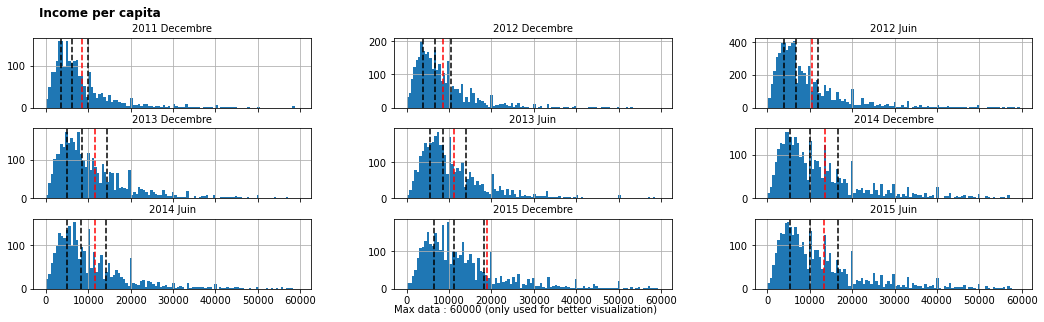

In [14]:
plot_var(df2a, var = 'rev_percap', title_plot = "Income per capita", maxdata=60000)

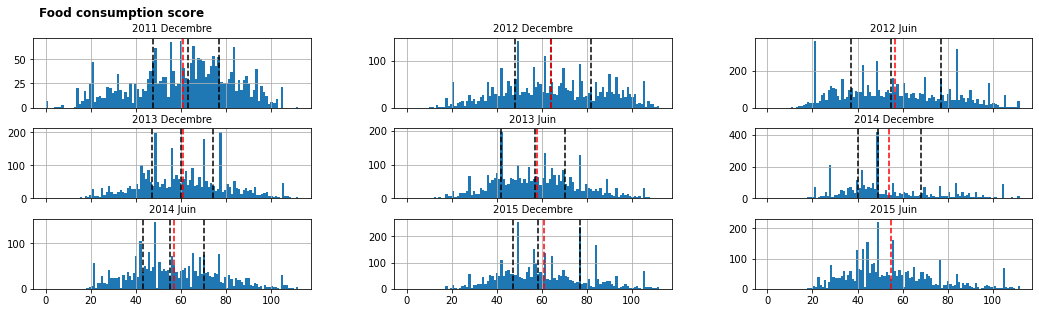

In [15]:
plot_var(df2a, var = 'fcs', title_plot = "Food consumption score")